# 🐝 Honey Bee Pollen Detection

<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTbduOtq3NYw7FDg2GuyPF1vEYfGBZ-CYvIng&usqp=CAU'>

From images of honeybees, let's try to detect if the bee is carying pollen.

# Getting Started

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Read the CSV file containing the labels
data = pd.read_csv('../input/honey-bee-pollen/PollenDataset/pollen_data.csv', usecols=['filename', 'pollen_carrying'])
data

filename  pollen_carrying
0     P10057-125r.jpg                1
1     P57380-120r.jpg                1
2    NP63671-221r.jpg                0
3     NP53776-47r.jpg                0
4    NP13382-201r.jpg                0
..                ...              ...
709  NP64239-233r.jpg                0
710  NP10304-132r.jpg                0
711  NP28671-238r.jpg                0
712   P14163-218r.jpg                1
713    NP1768-11r.jpg                0

[714 rows x 2 columns]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   filename         714 non-null    object
 1   pollen_carrying  714 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.3+ KB


# Preprocessing

In [4]:
def preprocess_df(df):
    df = df.copy()
    
    # Change filenames into filepaths
    image_path = '../input/honey-bee-pollen/PollenDataset/images/'
    df['filename'] = df['filename'].apply(lambda x: image_path / Path(x)).astype(str)
    
    # Create text labels for the images
    df['pollen_carrying'] = df['pollen_carrying'].map({0: "No Pollen", 1: "Pollen"})
    
    # Train-test split
    df_train, df_test = train_test_split(df, train_size=0.8, shuffle=True, random_state=0)
    
    return df_train, df_test

In [5]:
# Get preprocessed dataframes
df_train, df_test = preprocess_df(data)

# Creating Generators

Permits to use data one batch after the other in order to prevent running out of memory.

In [6]:
# Create training generator
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create test generator
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

Now we can flow the images from the generators with the paths.

**Notes:**
- *dataframe:* df from where to flow
- *x_cols:* filenames of the images
- *y_cols:* target classes
- *target_size:* shape to resize images
- *batch_size:* number of images per batch
- *shuffle / seed:* shuffle the images according to the seed
- The training generator is divided into 2 subsets (training and validation: 80% / 20%).
- Images are colorized and the target is binary (*Pollen* / *No Pollen*).

In [7]:
# Generate training images
train_images = train_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='filename',
    y_col='pollen_carrying',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

# Generate validation images
val_images = train_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='filename',
    y_col='pollen_carrying',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

# Generate test images
test_images = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='filename',
    y_col='pollen_carrying',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 457 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.
Found 143 validated image filenames belonging to 2 classes.


# Display of some images

Let's display some images of the honeybees and their associated labels.

In [8]:
# First batch shape
test_images[0][0].shape # [batch number][0: image array / 1: label]

(32, 224, 224, 3)

The generator is composed of several batches of 32 images + label.

They are composed of 224 x 224 pixels and 3 channels (RGB).

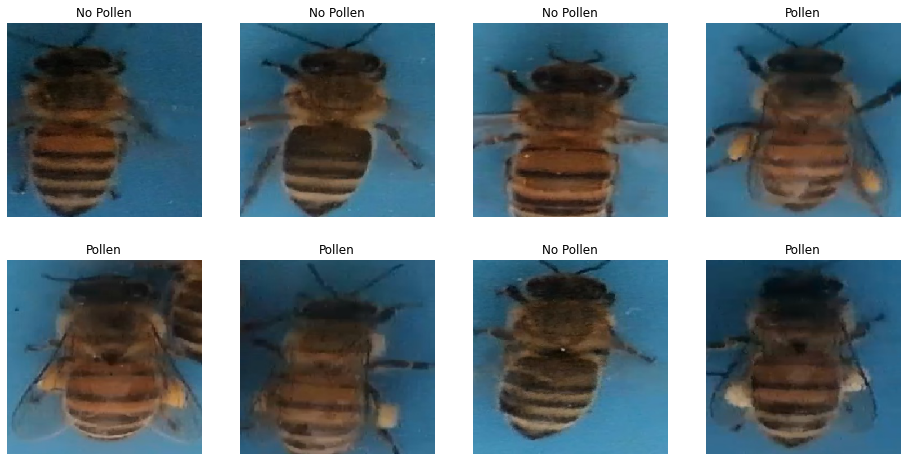

In [9]:
# Display of a few examples
plt.figure(figsize=(16, 8))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(test_images[0][0][i+10])
    plt.title("No Pollen" if test_images.labels[i+10] == 0 else "Pollen")
    plt.axis('off')
    
plt.show()

It is possible to identify the **yellow pollen sacks** carried by the honeybees. The model must learn to recognize them by extracting this feature with the *CNN*.

The pollen sacks can be really small or out of the frame depending on the picture. This might result in prediction errors.

# Training

We are going to create a **Convolutional Neural Network**, also called **CNN** that will be trained with the training images.

The images will be passed into different layers doing *filtering* and *pooling* until the number of features are reduced.

The classification is then made by a standard neural network.

First, let's create the layers for the deep learning model.

In [10]:
# Extract the features
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Classifier (standard neural network)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

2022-10-15 11:46:24.885049: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


**About the extraction layers:**
- The inputs layer takes one image with shape (224, 224, 3).
- It is followed by a a convolutional layer whose purpose is to "extract" low level features from the image with several filters.
- Then, the max-pooling layer reduces the number of features by losing information.
- A second convolutional layer "extract" high level features from the images.
- Again, a second max-pooling layer is applied and drop information.
- Global Average Pooling reduces the features to 1D by taking the average over the first two dimensions of each 32 filters.

**About the standard neural network layers:**
- It takes in inputs the previous 32 extracted features.
- There are then two layers of 128 neurons with relu activation.
- Finally, the previous layer is linked to a single neuron giving a prediction (probability) between 0 and 1.

In [11]:
# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# History
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

2022-10-15 11:46:25.324820: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
15/15 [==============================] - 7s 369ms/step - loss: 0.6938 - accuracy: 0.5208 - val_loss: 0.6927 - val_accuracy: 0.5088
Epoch 2/100
15/15 [==============================] - 5s 305ms/step - loss: 0.6948 - accuracy: 0.5208 - val_loss: 0.6954 - val_accuracy: 0.5088
Epoch 3/100
15/15 [==============================] - 4s 269ms/step - loss: 0.6912 - accuracy: 0.5208 - val_loss: 0.6926 - val_accuracy: 0.5088
Epoch 4/100
15/15 [==============================] - 4s 276ms/step - loss: 0.6910 - accuracy: 0.5208 - val_loss: 0.6919 - val_accuracy: 0.5088
Epoch 5/100
15/15 [==============================] - 4s 271ms/step - loss: 0.6910 - accuracy: 0.5208 - val_loss: 0.6907 - val_accuracy: 0.5088
Epoch 6/100
15/15 [==============================] - 4s 271ms/step - loss: 0.6890 - accuracy: 0.5208 - val_loss: 0.6890 - val_accuracy: 0.5088
Epoch 7/100
15/15 [==============================] - 4s 273ms/step - loss: 0.6868 - accuracy: 0.5208 - val_loss: 0.6846 - val_accuracy: 0.5088

The model has stopped when starting to overfit, thanks to the *callbacks*. It keeps the parameters of the lowest validation loss (*vall_loss*).

We want a model that is able to perform a **high score on new data** (the validation data), and not on the training data only (*overfitting*).

# Results

Now the model is trained, it is time to try it on the **test set**. It contains images that the model **has neven seen before**.



In [12]:
# Print accuracy (Percentage of correct predictions)
results = model.evaluate(test_images, verbose=0)
print("Accuracy: {:.2f} %".format(results[1] * 100))

Accuracy: 90.21 %


In [13]:
# Confusion matrix and classification report
predictions = np.squeeze(model.predict(test_images) >= 0.5).astype(int)
cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["No Pollen", "Pollen"])

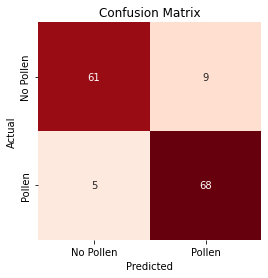

Classification Report:
----------------------
               precision    recall  f1-score   support

   No Pollen       0.92      0.87      0.90        70
      Pollen       0.88      0.93      0.91        73

    accuracy                           0.90       143
   macro avg       0.90      0.90      0.90       143
weighted avg       0.90      0.90      0.90       143



In [14]:
# Display
plt.figure(figsize=(4, 4))

sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Reds', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Pollen", "Pollen"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Pollen", "Pollen"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

print("Classification Report:\n----------------------\n", clr)

As we can see, the model gives pretty good results. It has been able to identify the pollen sacks from the sides of the honeybees.

**Reminder concerning the metrics:**
- The **accuracy** is the ratio of the correct predictions over the wrong predictions: (TP + TN) / (TP + TN + FP + FN). 
- The **precision** is defined by the amount of correct predictions of a class over the predicted amount of the class: TP / (TP + FP) for a positive class.
- The **recall** is defined by the amount of correct predictions of a class over the real total amount of the class: TP / (TP + FN) for a positive class.
- The **f1-score** is a combination of both precision and recall because it is easy to maximize one or the other despite the second: 2 * (prec * recall) / (prec + recall).

# Display of the predictions

Let's display the predictions of the first four batches of honeybees. In **blue are the correct** predictions while the **wrong ones are in red**.

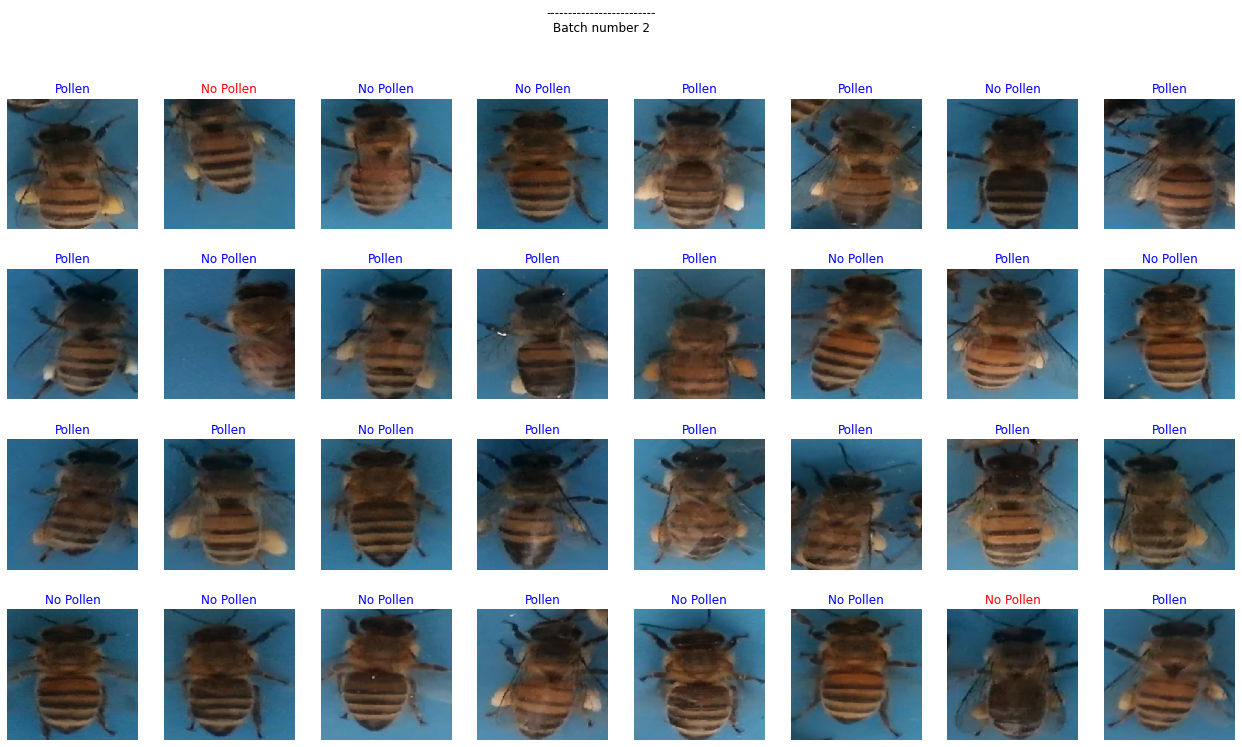

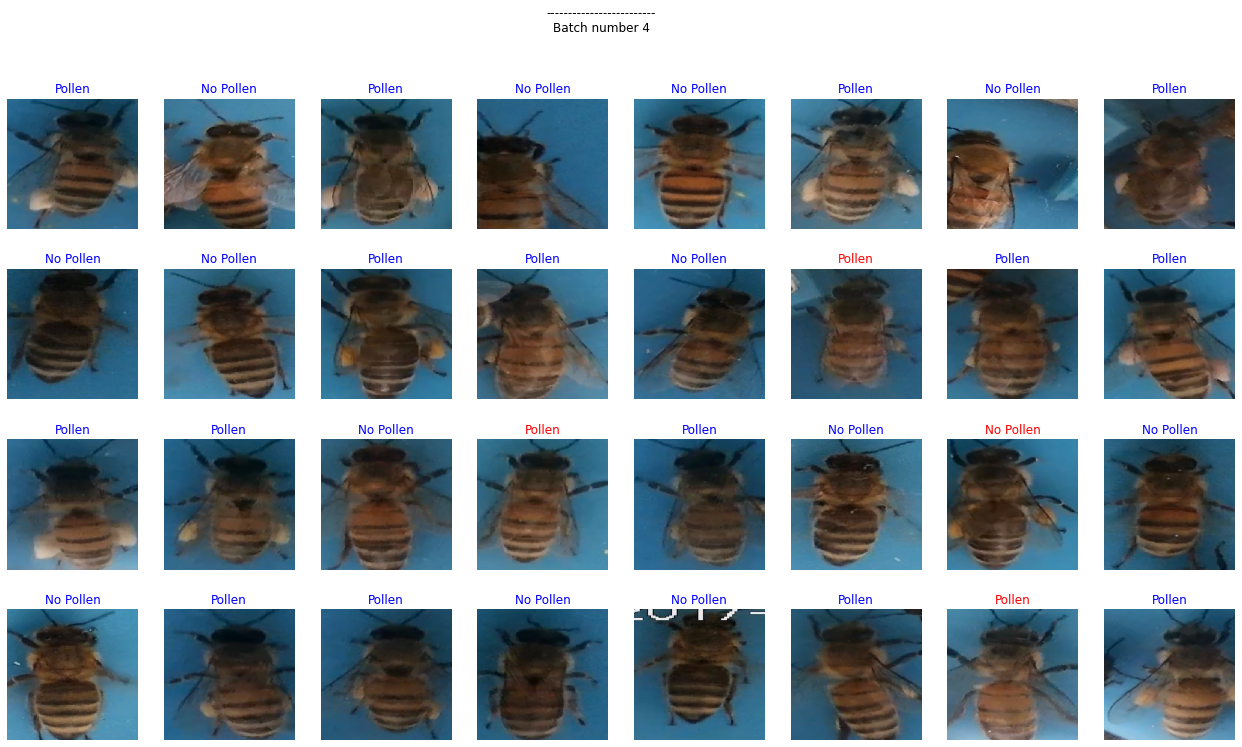

In [15]:
# Batch predictions
for batch in range(4):
    
    plt.figure(figsize=(22, 12))
    plt.suptitle(f"-------------------------\nBatch number {batch + 1}")
    
    for i in range(32):
        plt.subplot(4, 8, i+1)
        plt.imshow(test_images[batch][0][i])
        plt.title("No Pollen" if predictions[i+32*batch] == 0 else "Pollen",
                 color='blue' if predictions[i+32*batch] == test_images.labels[i+32*batch] else 'red')
        plt.axis('off')
    
plt.show()

By analysing incorrect predictions, it is sometimes difficult to understand why the model was wrong.

Sometimes it is due to the bad framing, but not always. The problem with deep learning is that the model works as a *black box*.

In a further notebook, I will highlight the filtering and pooling steps in order to better visualize them.

**Thank you for reading. Please let me know if you have any suggestion!** 🍯🐝